In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem Description
In this Kaggle competition, the task is to classify small image patches extracted from larger digital pathology scans as either metastatic cancer or non-cancerous. The goal is to build a binary image classification model to accurately identify metastatic cancer in these patches.

The dataset provided for the competition consists of image patches along with their corresponding labels (0 for non-cancerous and 1 for metastatic cancer). The images are in a digital format and can be processed using computer vision techniques.

In [2]:
!pip install --upgrade pip
!pip install seaborn
!pip install plotly
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [3]:
import warnings
import string
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

# Work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator

# Model Development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas_profiling as pp
from tifffile import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation

# Exploratory Data Analysis (EDA)
In this section, we will explore the dataset to gain insights into its characteristics and understand any patterns or trends. Some steps to consider during EDA:

Load the dataset: Read the provided dataset and necessary libraries.
Data visualization: Visualize sample images from both classes (cancerous and non-cancerous) to get an understanding of the data.
Data distribution: Analyze the distribution of the classes to determine if the dataset is balanced or imbalanced.
Data preprocessing: If required, perform any preprocessing steps such as resizing images, normalizing pixel values, or augmenting the dataset to improve model performance.

In [4]:
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [5]:
def basic_task(train,set_first):
    if set_first == '1':
        print("The number of Null Values in our dataset")
#         print(train.isnull().sum())
#         print(train.isna())
        if train.isnull().values.sum() > 1:
            train.dropna(inplace=True)
        print("This is how our data looks like")
#         print(train['Text'].head())


        train.describe()
        print("Number of articles that are unique")

#         print(train['ArticleId'].nunique())
        profiler(train)
        train.info()

def profiler(train):
    profile = pp.ProfileReport(train, title="Pandas Profiling Report", explorative=True)
    profile.to_notebook_iframe()
    profile.to_file("first_profile.html")

    

    print("Generating Data Frame Profile")

In [6]:
basic_task(train_data,set_first='1')

The number of Null Values in our dataset
This is how our data looks like
Number of articles that are unique


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Data Frame Profile
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
def plotter(train,hist):
    if hist=='1':
        
        sns.countplot(x=train['label'], palette='colorblind').set(title='Label and Counts');
        fig = px.pie(train_data, 
             values = train_data['label'].value_counts().values, 
             names = train_data['label'].unique())
        fig.update_layout(
            title={
                'text': "Label Percentage Pie Chart",
                
                'xanchor': 'center',
                'yanchor': 'top'})
        fig.show()

   Label Counts
0        130908
1         89117


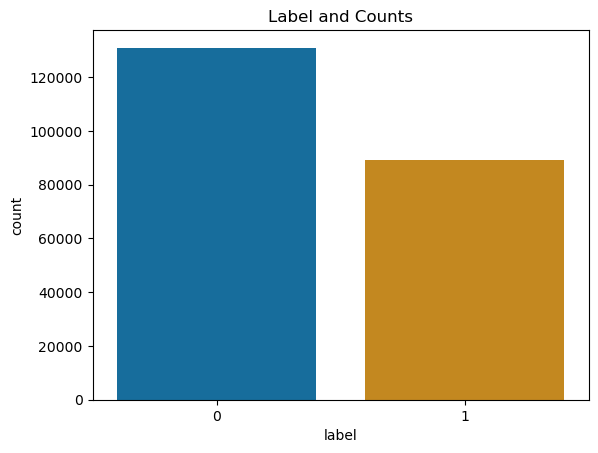

In [8]:
print(pd.DataFrame(data={'Label Counts': train_data['label'].value_counts()}))
plotter(train_data,hist='1')

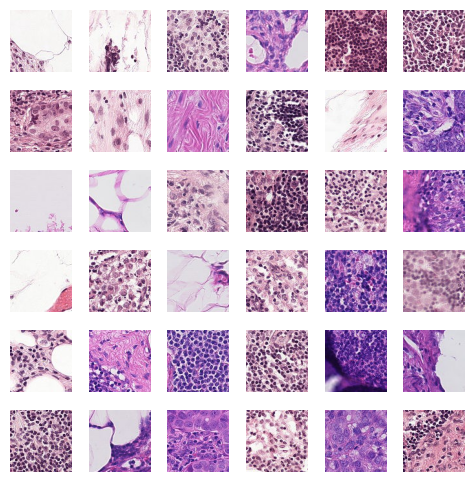

In [9]:
images_train = train_data
images_train['label'] = images_train['label'].astype(str)
images_train['id'] = train_data['id'] + '.tif'
rows, cols = 6, 6

fig, axes = plt.subplots(rows, cols, figsize=(6, 6))

for i in range(6 * 6):
    image = imread(train_path + images_train['id'][i])

    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

plt.show()

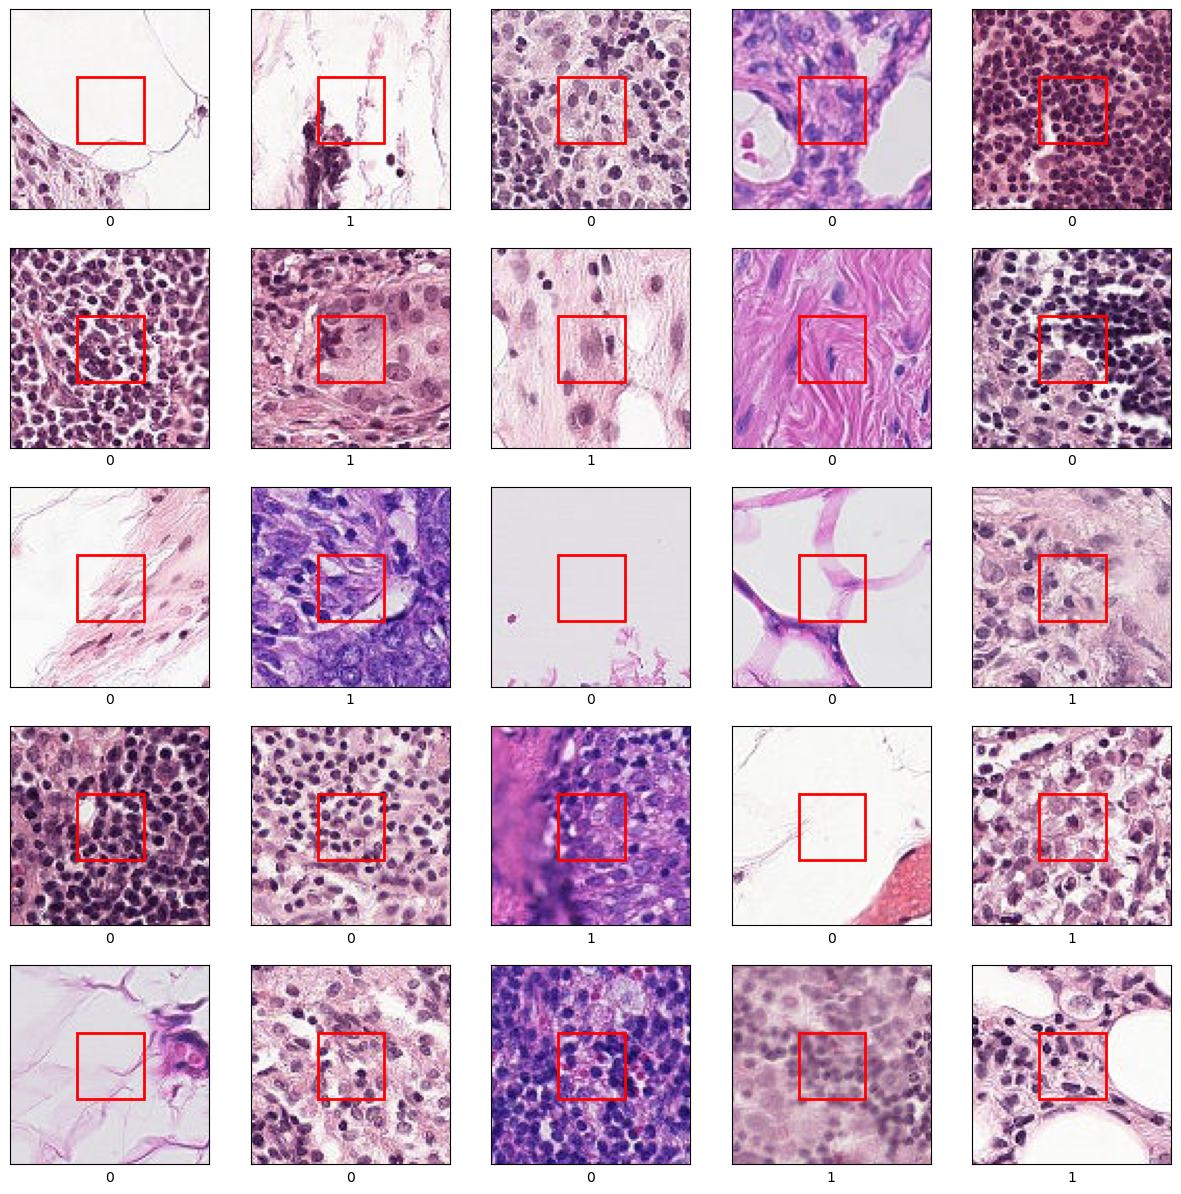

In [10]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    file = str(train_path + images_train.id[i] )
    image = io.imread(file)
    axis.imshow(image)
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
    axis.add_patch(box)
    axis.set(xticks=[], yticks=[], xlabel = images_train.label[i]);

In [11]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

# Analysis (Model Building and Training)
In this section, we will build and train a model for the image classification task. Here's a step-by-step approach to consider:

Split the dataset: Divide the dataset into training, validation, and testing sets to evaluate model performance.
Model selection: Choose an appropriate model architecture for image classification (e.g., CNN, ResNet, Inception, etc.).
Model configuration: Set up the model by defining its layers, activation functions, optimization algorithm, and loss function.
Model training: Train the model using the training set and monitor its performance on the validation set. Adjust hyperparameters as necessary (e.g., learning rate, batch size, etc.).
Model evaluation: Evaluate the trained model on the testing set to assess its generalization performance. Calculate relevant metrics such as accuracy, precision, recall, and F1-score.

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
RANDOM_STATE = 49
BATCH_SIZE = 256
# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is set up successfully.")
    except RuntimeError as e:
        print(e)

# Define the train and validation data split
train, valid = train_test_split(train_data, test_size=0.2)

# Define the data generators
train_datagen =  ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

test_datagen =  ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

# Set up the data generators with GPU support
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64)) 

# Train your model using the data generators


Found 187022 validated image filenames belonging to 2 classes.
Found 33003 validated image filenames belonging to 2 classes.


In [13]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()


In [15]:
import tensorflow as tf
ROC_1 = tf.keras.metrics.AUC()

# use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is set up successfully.")
    except RuntimeError as e:
        print(e)

# Define the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', ROC_1])

# Set the batch size
batch_size = 15

# Build the model
model.build(input_shape=(batch_size, 64, 64, 3))

# Display the model summary
model.summary()

# Train your model



hist = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (15, 62, 62, 16)          448       
                                                                 
 conv2d_5 (Conv2D)           (15, 60, 60, 16)          2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (15, 30, 30, 16)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (15, 28, 28, 32)          4640      
                                                                 
 conv2d_7 (Conv2D)           (15, 26, 26, 32)          9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (15, 13, 13, 32)         0         
 2D)                                                  

# Results
In this section, report the results obtained from the trained model. Include:

Evaluation metrics: Present the accuracy, precision, recall, and F1-score of the model on the testing set.
Confusion matrix: Visualize the confusion matrix to analyze the distribution of true positives, true negatives, false positives, and false negatives.

In [39]:
# predictions = model.predict(test_generator, verbose=1)
model.summary()

AttributeError: 'KerasClassifier' object has no attribute 'summary'

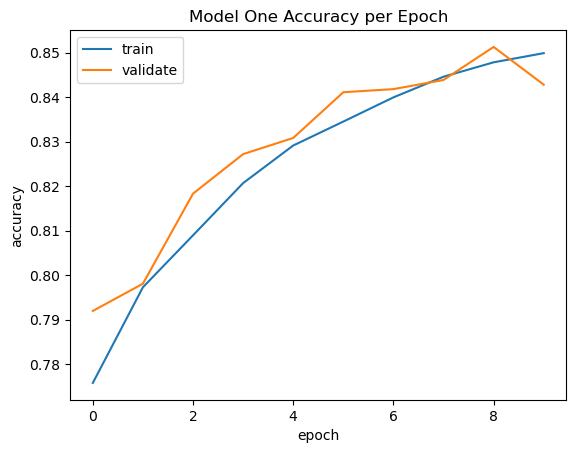

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [20]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [21]:
submission_df = pd.DataFrame({'id':os.listdir(test_path)})
submission_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [22]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [37]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         # original image = (96, 96) 
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [38]:
predictions = model.predict(test_generator, verbose=1)

AttributeError: 'KerasClassifier' object has no attribute 'model'

In [ ]:
predictions = np.transpose(predictions)[0]
copy_df = pd.DataFrame()
copy_df['id'] = submission_df['id'].apply(lambda x: x.split('.')[0])
copy_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
copy_df.head()

In [ ]:
copy_df['label'].value_counts()

In [ ]:
copy_df.to_csv('submission.csv', index=False)